In [1]:
% matplotlib inline

In [2]:
import numpy as np
from collections import Counter
import gc

In [3]:
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn import svm
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.neighbors import KDTree
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
from Utils import plot_confusion_matrix, annotate_confusion, feature_extraction, smooth_result

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.style.use('default')
mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.size"] = 7
mpl.rcParams["font.family"] = 'sans-serif'
mpl.rcParams["font.sans-serif"] = 'Arial'
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['text.usetex'] = False
mpl.rcParams["figure.figsize"] = [3.5, 3.5]

In [6]:
train_data = np.loadtxt('./data/Vaihingen3D_Traininig_fpfh_5_ground.txt', skiprows=11)
train_data_feature = feature_extraction(train_data)
train_data_class = train_data[:, 34]

test_data = np.loadtxt('./data/Vaihingen3D_EVAL_WITH_REF_fpfh_5_ground.txt', skiprows=11)
test_data_feature = feature_extraction(test_data)
test_data_class = test_data[:, 34]

class_name =  ['PL', 'LV', 'IS', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

In [7]:
# scale training and testing data 

scaler = preprocessing.StandardScaler().fit(train_data_feature)
train_data_feature = scaler.transform(train_data_feature)
test_data_feature = scaler.transform(test_data_feature)

#### Prameter tuning ($C$)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(train_data_feature, 
#                                                    train_data_class, train_size = 0.05, test_size=0.05, random_state=42)
# svc = svm.SVC(cache_size=1000, probability=False, gamma='scale')
# parameters1 = {'C':[1/10.0, 1/8.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 4, 6, 8, 10]}
# gsearch1 = GridSearchCV(svc, parameters1, cv=5, )
# gsearch1.fit(X_train, y_train)
# joblib.dump(gsearch1, './result/classifier/GridSearchCV_SVC_without_intensity.joblib')
gsearch1 = joblib.load('./result/classifier/GridSearchCV_SVC_without_intensity.joblib')

In [9]:
'''
plt.figure(figsize=[3.5,2])
plt.plot(np.arange(11), gsearch1.cv_results_['mean_test_score'], label='test')
plt.plot(np.arange(11), gsearch1.cv_results_['mean_train_score'], label='train')
plt.legend()
'''

"\nplt.figure(figsize=[3.5,2])\nplt.plot(np.arange(11), gsearch1.cv_results_['mean_test_score'], label='test')\nplt.plot(np.arange(11), gsearch1.cv_results_['mean_train_score'], label='train')\nplt.legend()\n"

In [10]:
# parameters2 = {'C':[10,15,20,25,30]}
# gsearch2 = GridSearchCV(svc, parameters2, cv=5)
# gsearch2.fit(X_train, y_train)
# joblib.dump(gsearch2, './result/classifier/GridSearchCV2_SVC_without_intensity.joblib')
gsearch2 = joblib.load('./result/classifier/GridSearchCV2_SVC_without_intensity.joblib')

In [11]:
import pickle

In [12]:
# parameters3 = {'C':[40, 50, 60, 70, 80 ,90, 100, 200]}
# gsearch3 = GridSearchCV(svc, parameters3, cv=5)
# gsearch3.fit(X_train, y_train)
# with open("./result/classifier/GridSearchCV3_SVC_without_intensity.pkl","wb") as file:
#    pickle.dump(gsearch3_cv_results_, file)

with open("./result/classifier/GridSearchCV3_SVC_without_intensity.pkl","rb") as file:
    gsearch3_cv_results_ = pickle.load(file)

In [13]:
test_score = list(gsearch1.cv_results_['mean_test_score'][5:-1]) + list(gsearch2.cv_results_['mean_test_score']) + list(gsearch3_cv_results_['mean_test_score'][:-1])
train_score = list(gsearch1.cv_results_['mean_train_score'][5:-1]) + list(gsearch2.cv_results_['mean_train_score']) + list(gsearch3_cv_results_['mean_train_score'][:-1])

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [14]:
axis_x = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90 ,100]

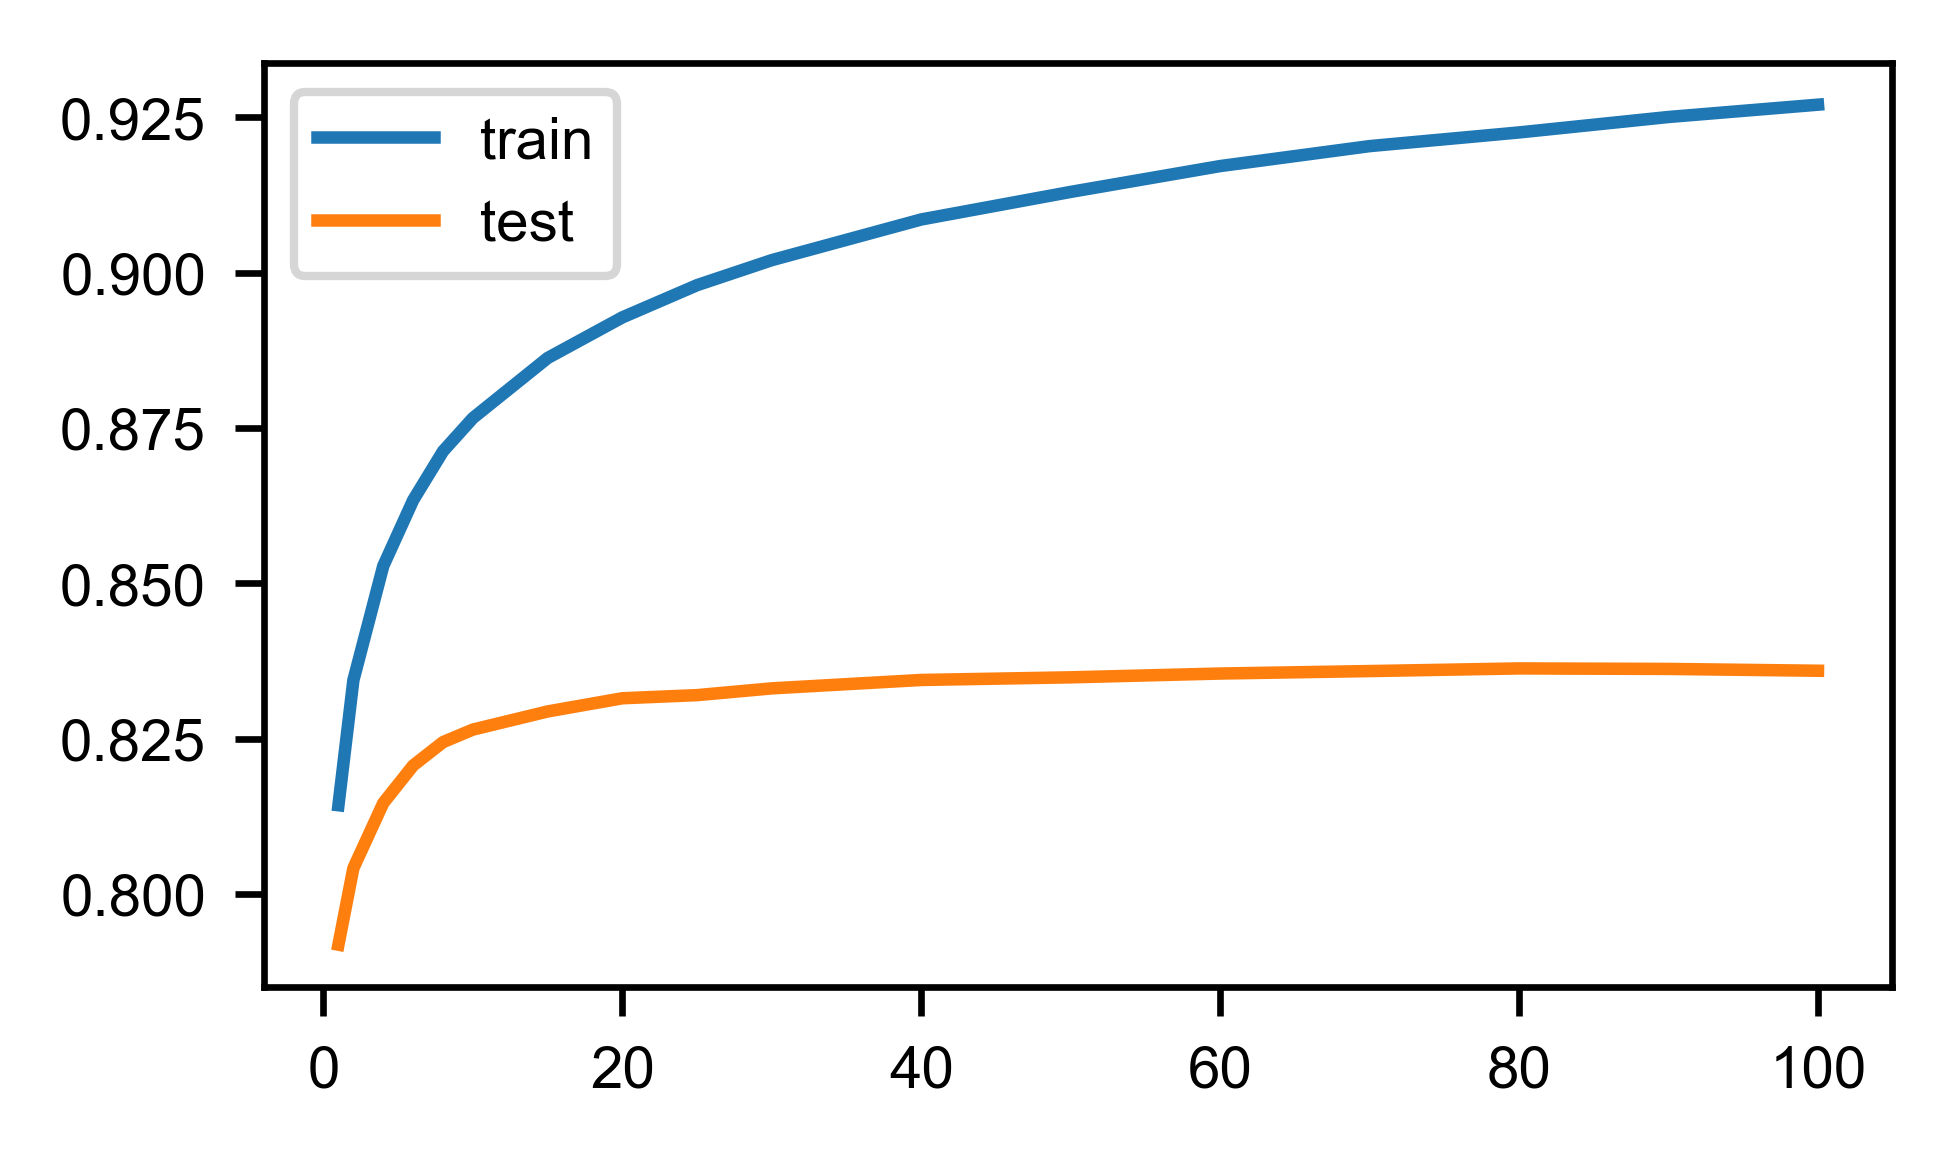

In [15]:
plt.figure(figsize=[3.5,2])
plt.plot(axis_x, train_score, label='train')
plt.plot(axis_x, test_score, label='test')
plt.legend()

#### SVC without intensity ($C=40$)

In [16]:
'''
X_train, X_test, y_train, y_test = train_test_split(train_data_feature, 
                                                    train_data_class, train_size = 0.1, test_size=0.1, random_state=42)
clf_SVC_without_i = svm.SVC(cache_size=1000, probability=True, gamma='scale', C=40)
clf_SVC_without_i.fit(X_train, y_train)
joblib.dump(clf_SVC_without_i, './result/classifier/SVC_without_intensity.joblib')
'''
clf_SVC_without_i = joblib.load('./result/classifier/SVC_without_intensity.joblib')

In [17]:
SVC_without_i = clf_SVC_without_i.predict(test_data_feature)

test_xyz = test_data[:, -3:] 
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
smooth_SVC_without_i = smooth_result(SVC_without_i, ind)

tmp = np.hstack([test_xyz, smooth_SVC_without_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_without_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [18]:
tmp = smooth_SVC_without_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_without_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [19]:
precision_recall_fscore_support(test_data_class,smooth_SVC_without_i, average='weighted')

(0.733377315919965, 0.7191332986821205, 0.7218153316931766, None)

In [20]:
precision_recall_fscore_support(test_data_class,smooth_SVC_without_i)

(array([0.07936508, 0.67384943, 0.82386675, 0.5693711 , 0.3327787 ,
        0.91285324, 0.29807036, 0.33099615, 0.65814823]),
 array([0.04166667, 0.73037795, 0.79730551, 0.31984898, 0.13473457,
        0.76337026, 0.4280114 , 0.36711258, 0.79884188]),
 array([0.05464481, 0.70097589, 0.81036854, 0.40960111, 0.19180972,
        0.83144642, 0.35141363, 0.34812013, 0.72170204]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

#### Probability

In [21]:
# predict_test_proba = clf_SVC_without_i.predict_proba(test_data_feature)
# np.save('./result/classification_result/SVC_predict_pro.npy', predict_test_proba)
predict_test_proba = np.load('./result/classification_result/SVC_predict_pro.npy')

#### GMM for intensity of impervious surface and low vegetation classified by SVC without intensity

In [22]:
# smooth the intensity of LiDAR
test_i = test_data[:, -7]
neigh_i = test_i[ind]
smooth_test_i = np.average(neigh_i, axis=1)

In [23]:
# Gaussian mixture model for the intensity of low vegetation and impervious surface.
SVC_lv_im_i = smooth_test_i[np.logical_or(SVC_without_i == 1, SVC_without_i == 2)]
SVC_lv_im_i = SVC_lv_im_i.reshape((-1, 1))
GMM = mixture.GaussianMixture(n_components=2, random_state=0)
GMM.fit(SVC_lv_im_i)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

#### Joint the classification of SVC without intensity and GMM

In [24]:
# calculate the ratio of larger and smaller for SVC without intensity
proba_SVC = predict_test_proba
proba_SVC_lv_im = proba_SVC[np.logical_or(SVC_without_i == 1, SVC_without_i == 2), 1:3]
ratio_proba_SVC_lv_im = np.zeros(proba_SVC_lv_im.shape[0])

proba_SVC_lv_larger_im = proba_SVC_lv_im[:, 0] > proba_SVC_lv_im[:, 1]
ratio_proba_SVC_lv_im[proba_SVC_lv_larger_im] = np.divide(proba_SVC_lv_im[proba_SVC_lv_larger_im, 0],
                                                        proba_SVC_lv_im[proba_SVC_lv_larger_im, 1])

proba_SVC_lv_smaller_im = np.logical_not(proba_SVC_lv_larger_im)
ratio_proba_SVC_lv_im[proba_SVC_lv_smaller_im] = np.divide(proba_SVC_lv_im[proba_SVC_lv_smaller_im, 1],
                                                         proba_SVC_lv_im[proba_SVC_lv_smaller_im,0])

In [25]:
# calculate the ratio of larger and smaller for GMM

proba_GMM_lv_im = GMM.predict_proba(SVC_lv_im_i)
ratio_proba_GMM_lv_im = np.zeros(proba_GMM_lv_im.shape[0])

proba_GMM_lv_larger_im = proba_GMM_lv_im[:, 1] > proba_GMM_lv_im[:, 0]
ratio_proba_GMM_lv_im[proba_GMM_lv_larger_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_larger_im, 1],
                                                    proba_GMM_lv_im[proba_GMM_lv_larger_im, 0])

proba_GMM_lv_smaller_im = np.logical_not(proba_GMM_lv_larger_im)
ratio_proba_GMM_lv_im[proba_GMM_lv_smaller_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_smaller_im, 0],
                                                     proba_GMM_lv_im[proba_GMM_lv_smaller_im, 1])

In [26]:
# the result for ground level points
SVC_lv_im = SVC_without_i[np.logical_or(SVC_without_i==1, SVC_without_i==2)]
GMM_lv_im = GMM.predict(SVC_lv_im_i)

# set the semantic label for GMM clusters 
GMM_lv_im = GMM_lv_im+1

In [27]:
# calculate the effect of joint coefficient on the performance of the joint classification
effect_a = {'f1_lv': [],
            'f1_im': [],
            'Acc': []}
tmp = list(1/np.arange(2, 21, 1))
tmp.reverse()
list_a = tmp + list(np.arange(1, 21, 1))
for a in list_a:
    judge = a * ratio_proba_SVC_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
    refine_lv_im = np.zeros(judge.shape)
    refine_lv_im[judge] = SVC_lv_im[judge]
    refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]
    
    joint_result = np.copy(SVC_without_i)
    joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im
    smooth_joint_result = smooth_result(joint_result, ind)
    effect_a['Acc'].append(precision_recall_fscore_support(test_data_class, joint_result, average='weighted')[2])
    
    tmp = precision_recall_fscore_support(test_data_class, smooth_joint_result)
    effect_a['f1_lv'].append(tmp[2][1])
    effect_a['f1_im'].append(tmp[2][2])
    
with open("./result/classifier/SVC_effect_a.pkl","wb") as f:
    pickle.dump(effect_a,f)
    
with open("./result/classifier/SVC_effect_a.pkl","rb") as f:
    effect_a = pickle.load(f)    

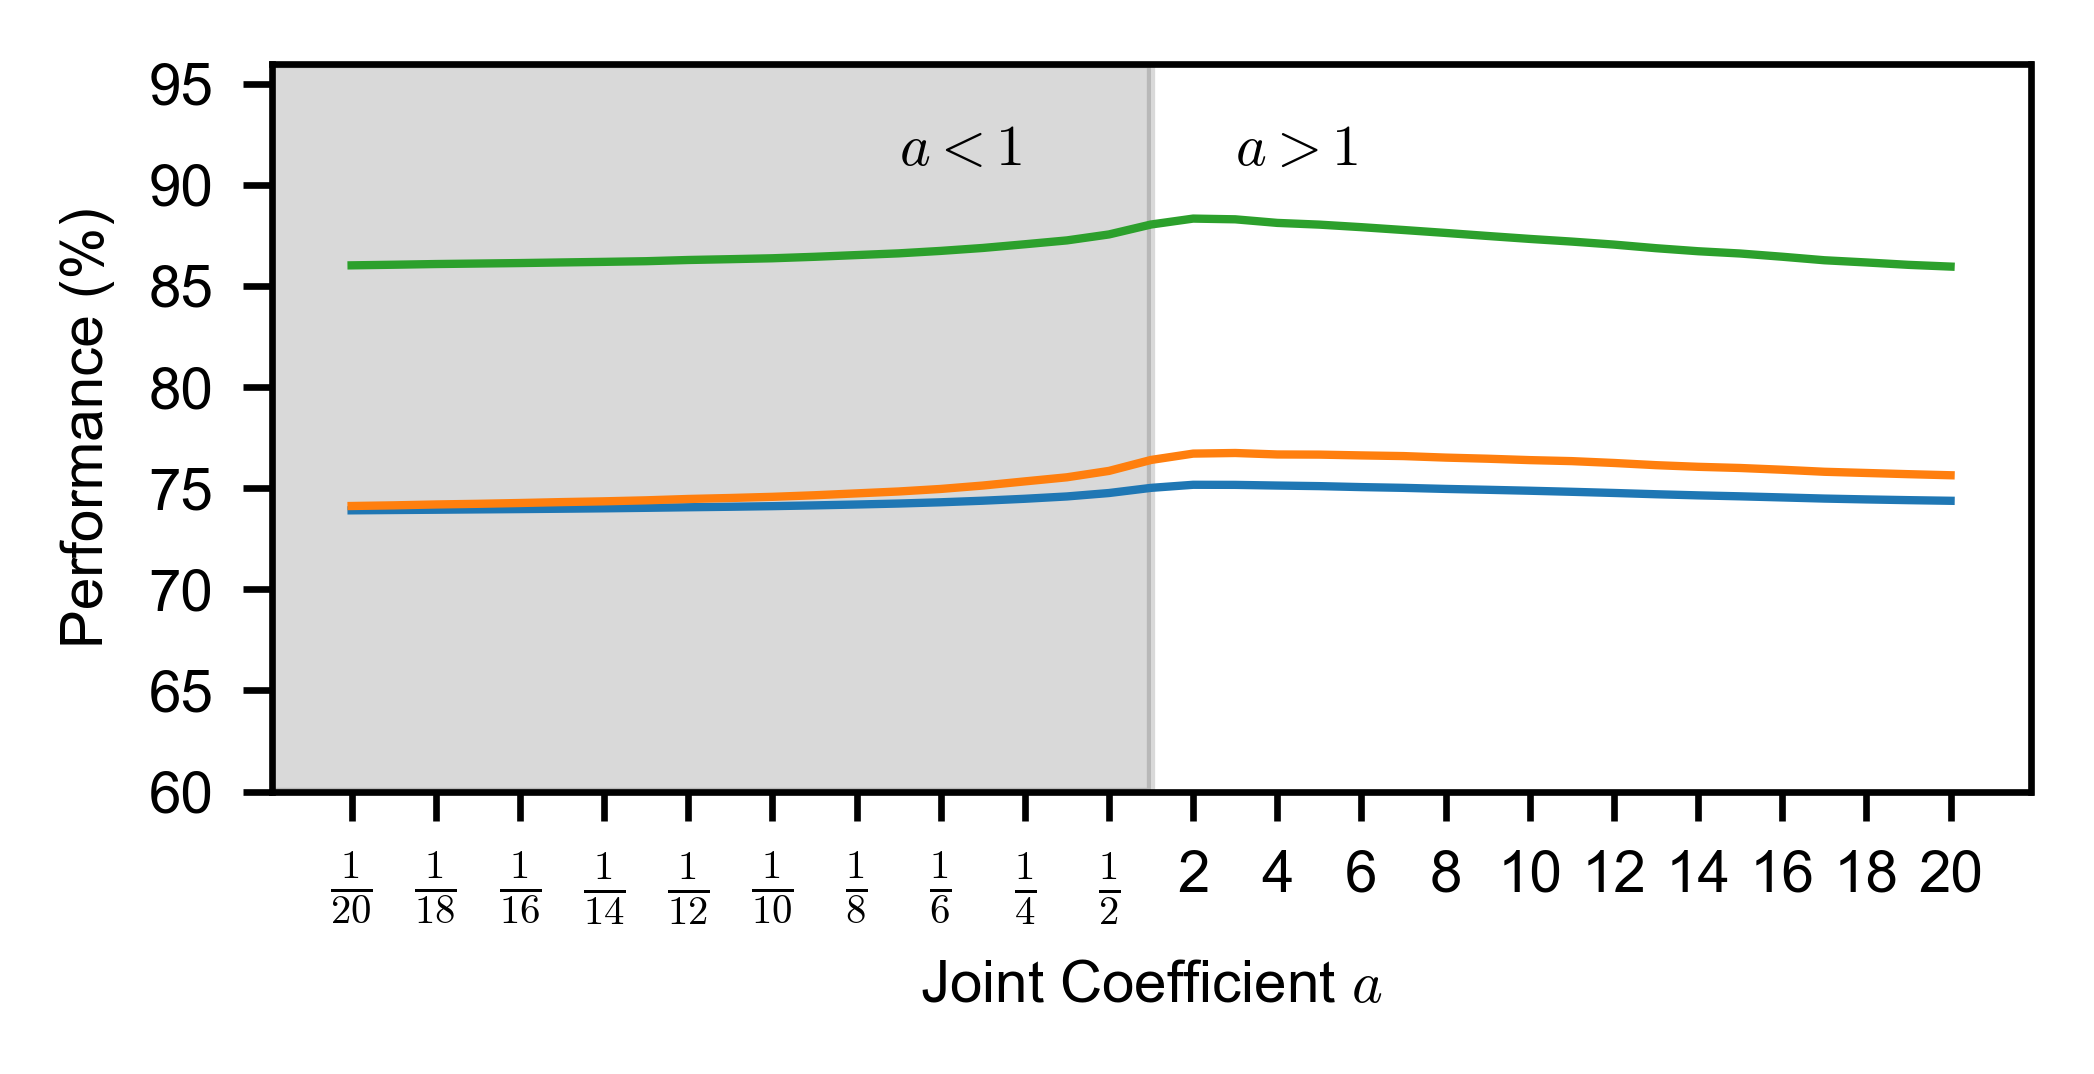

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 1.8))
x = x_ticks = np.arange(1, 40, 1)
ax.plot(x, effect_a['Acc'], label='Overall accuracy', lw=1)
ax.plot(x, effect_a['f1_lv'], label='F1 score of low vegetation', lw=1)
ax.plot(x, effect_a['f1_im'], label='F1 score of impervious surface', lw=1)
x_ticks = np.arange(1, 40, 2)
ax.set_xticks(x_ticks)

x_label = []
for i in range(2, 21, 2):
    x_label.append(r"$\frac{{{}}}{{{}}}$".format(1, i))
x_label.reverse()
for i in range(2, 21, 2):
    x_label.append(i)
ax.set_xticklabels(x_label)
ax.set_xlabel('Joint Coefficient $a$')


ax.set_ylim([0.6, 0.96])
ax.set_yticks(np.arange(0.6, 0.96, 0.05))
ax.set_yticklabels((np.arange(0.6, 0.96, 0.05)*100).astype('int'))
ax.set_ylabel('Performance (%)')

#ax.legend(loc=[0.41, 0.02], ncol=1)
ax.add_patch(Rectangle((-1, 0.6), 21, 0.36, color='black', alpha=0.15))
ax.text(14, 0.91, '$a<1$')
ax.text(22, 0.91, '$a>1$')

plt.tight_layout()
plt.savefig("./result/figure/SVC_effect_a.png")

In [29]:
a = 3                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_SVC_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im = np.zeros(judge.shape)
refine_lv_im[judge] = SVC_lv_im[judge]
refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]

joint_result = np.copy(SVC_without_i)
joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im

In [30]:
smooth_joint_result = smooth_result(joint_result, ind)
tmp = np.hstack([test_xyz, smooth_joint_result.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_joint_result.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_joint_result == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_joint_result_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [31]:
precision_recall_fscore_support(test_data_class, smooth_joint_result, average='weighted')

(0.7662152772074164, 0.753763461753319, 0.7557265686496292, None)

In [32]:
precision_recall_fscore_support(test_data_class, smooth_joint_result)

(array([0.07936508, 0.74600775, 0.88661058, 0.56787763, 0.33277926,
        0.91295194, 0.29793968, 0.33105554, 0.65804825]),
 array([0.04166667, 0.79003952, 0.87931677, 0.32038835, 0.13486931,
        0.76345279, 0.42774412, 0.3669917 , 0.79884188]),
 array([0.05464481, 0.76739253, 0.88294861, 0.40965517, 0.19194631,
        0.83153631, 0.35123272, 0.34809861, 0.72164193]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

### SVM with intensity

In [33]:
# smooth intensity
train_xyz = train_data[:, -3:]
intensity = train_data[:, -7]
kdt = KDTree(train_xyz, metric = 'euclidean')
ind = kdt.query(train_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

# scaler intesity data
scaler_intensity = preprocessing.StandardScaler().fit(smooth_intensity)
smooth_intensity = scaler_intensity.transform(smooth_intensity)
# concatenate intensity with other feature
train_data_feature_i = np.hstack((train_data_feature, smooth_intensity))

In [34]:
# same operation with training data
test_xyz = test_data[:, -3:]
intensity = test_data[:, -7]
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

smooth_intensity = scaler_intensity.transform(smooth_intensity)
test_data_feature_i = np.hstack((test_data_feature, smooth_intensity))

In [35]:
import time

In [36]:
start = time.clock()
X_train, X_test, y_train, y_test = train_test_split(train_data_feature_i, 
                                                    train_data_class, train_size = 0.1, test_size=0.1, random_state=42)
clf_SVC_i = svm.SVC(cache_size=1000, probability=False, gamma='scale', C=40)
clf_SVC_i.fit(X_train, y_train)
elapsed = (time.clock() - start)
joblib.dump(clf_SVC_i, './result/classifier/SVC_with_intensity.joblib')
clf_SVC_i = joblib.load('./result/classifier/SVC_with_intensity.joblib')


In [37]:
SVC_with_i = clf_SVC_i.predict(test_data_feature_i)
smooth_SVC_with_i = smooth_result(SVC_with_i, ind)
tmp = np.hstack([test_xyz, smooth_SVC_with_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_with_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_SVC_with_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/SVC_with_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [38]:
precision_recall_fscore_support(test_data_class, smooth_SVC_with_i, average='weighted')

(0.7690059637501608, 0.7554976416125444, 0.757892223852504, None)

In [39]:
precision_recall_fscore_support(test_data_class, smooth_SVC_with_i)

(array([0.07909605, 0.75607312, 0.87851173, 0.57765068, 0.36      ,
        0.92090022, 0.29757123, 0.32243801, 0.65979569]),
 array([0.04666667, 0.77990678, 0.89041633, 0.35409924, 0.14308812,
        0.76548859, 0.42899145, 0.36727375, 0.80160808]),
 array([0.05870021, 0.76780504, 0.88442397, 0.43905701, 0.20478211,
        0.83603331, 0.35139573, 0.34339857, 0.72382126]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

### The confusion matrix between SVC considering intensity and the proposed method

In [40]:
# the consistence between joint and SVC_i result
precision_recall_fscore_support(smooth_SVC_with_i, smooth_joint_result, average='weighted')[1]

0.9129874041221989

E:\als_fpfh_brf\Utils.py:70: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(confusion_matrix), **kwargs)
E:\als_fpfh_brf\Utils.py:136: RuntimeWarning: divide by zero encountered in log
  threshold = im.norm(np.log(data).max())/2.
E:\als_fpfh_brf\Utils.py:153: RuntimeWarning: divide by zero encountered in log
  kw.update(color=textcolors[im.norm(np.log(data[i, j])) > threshold])


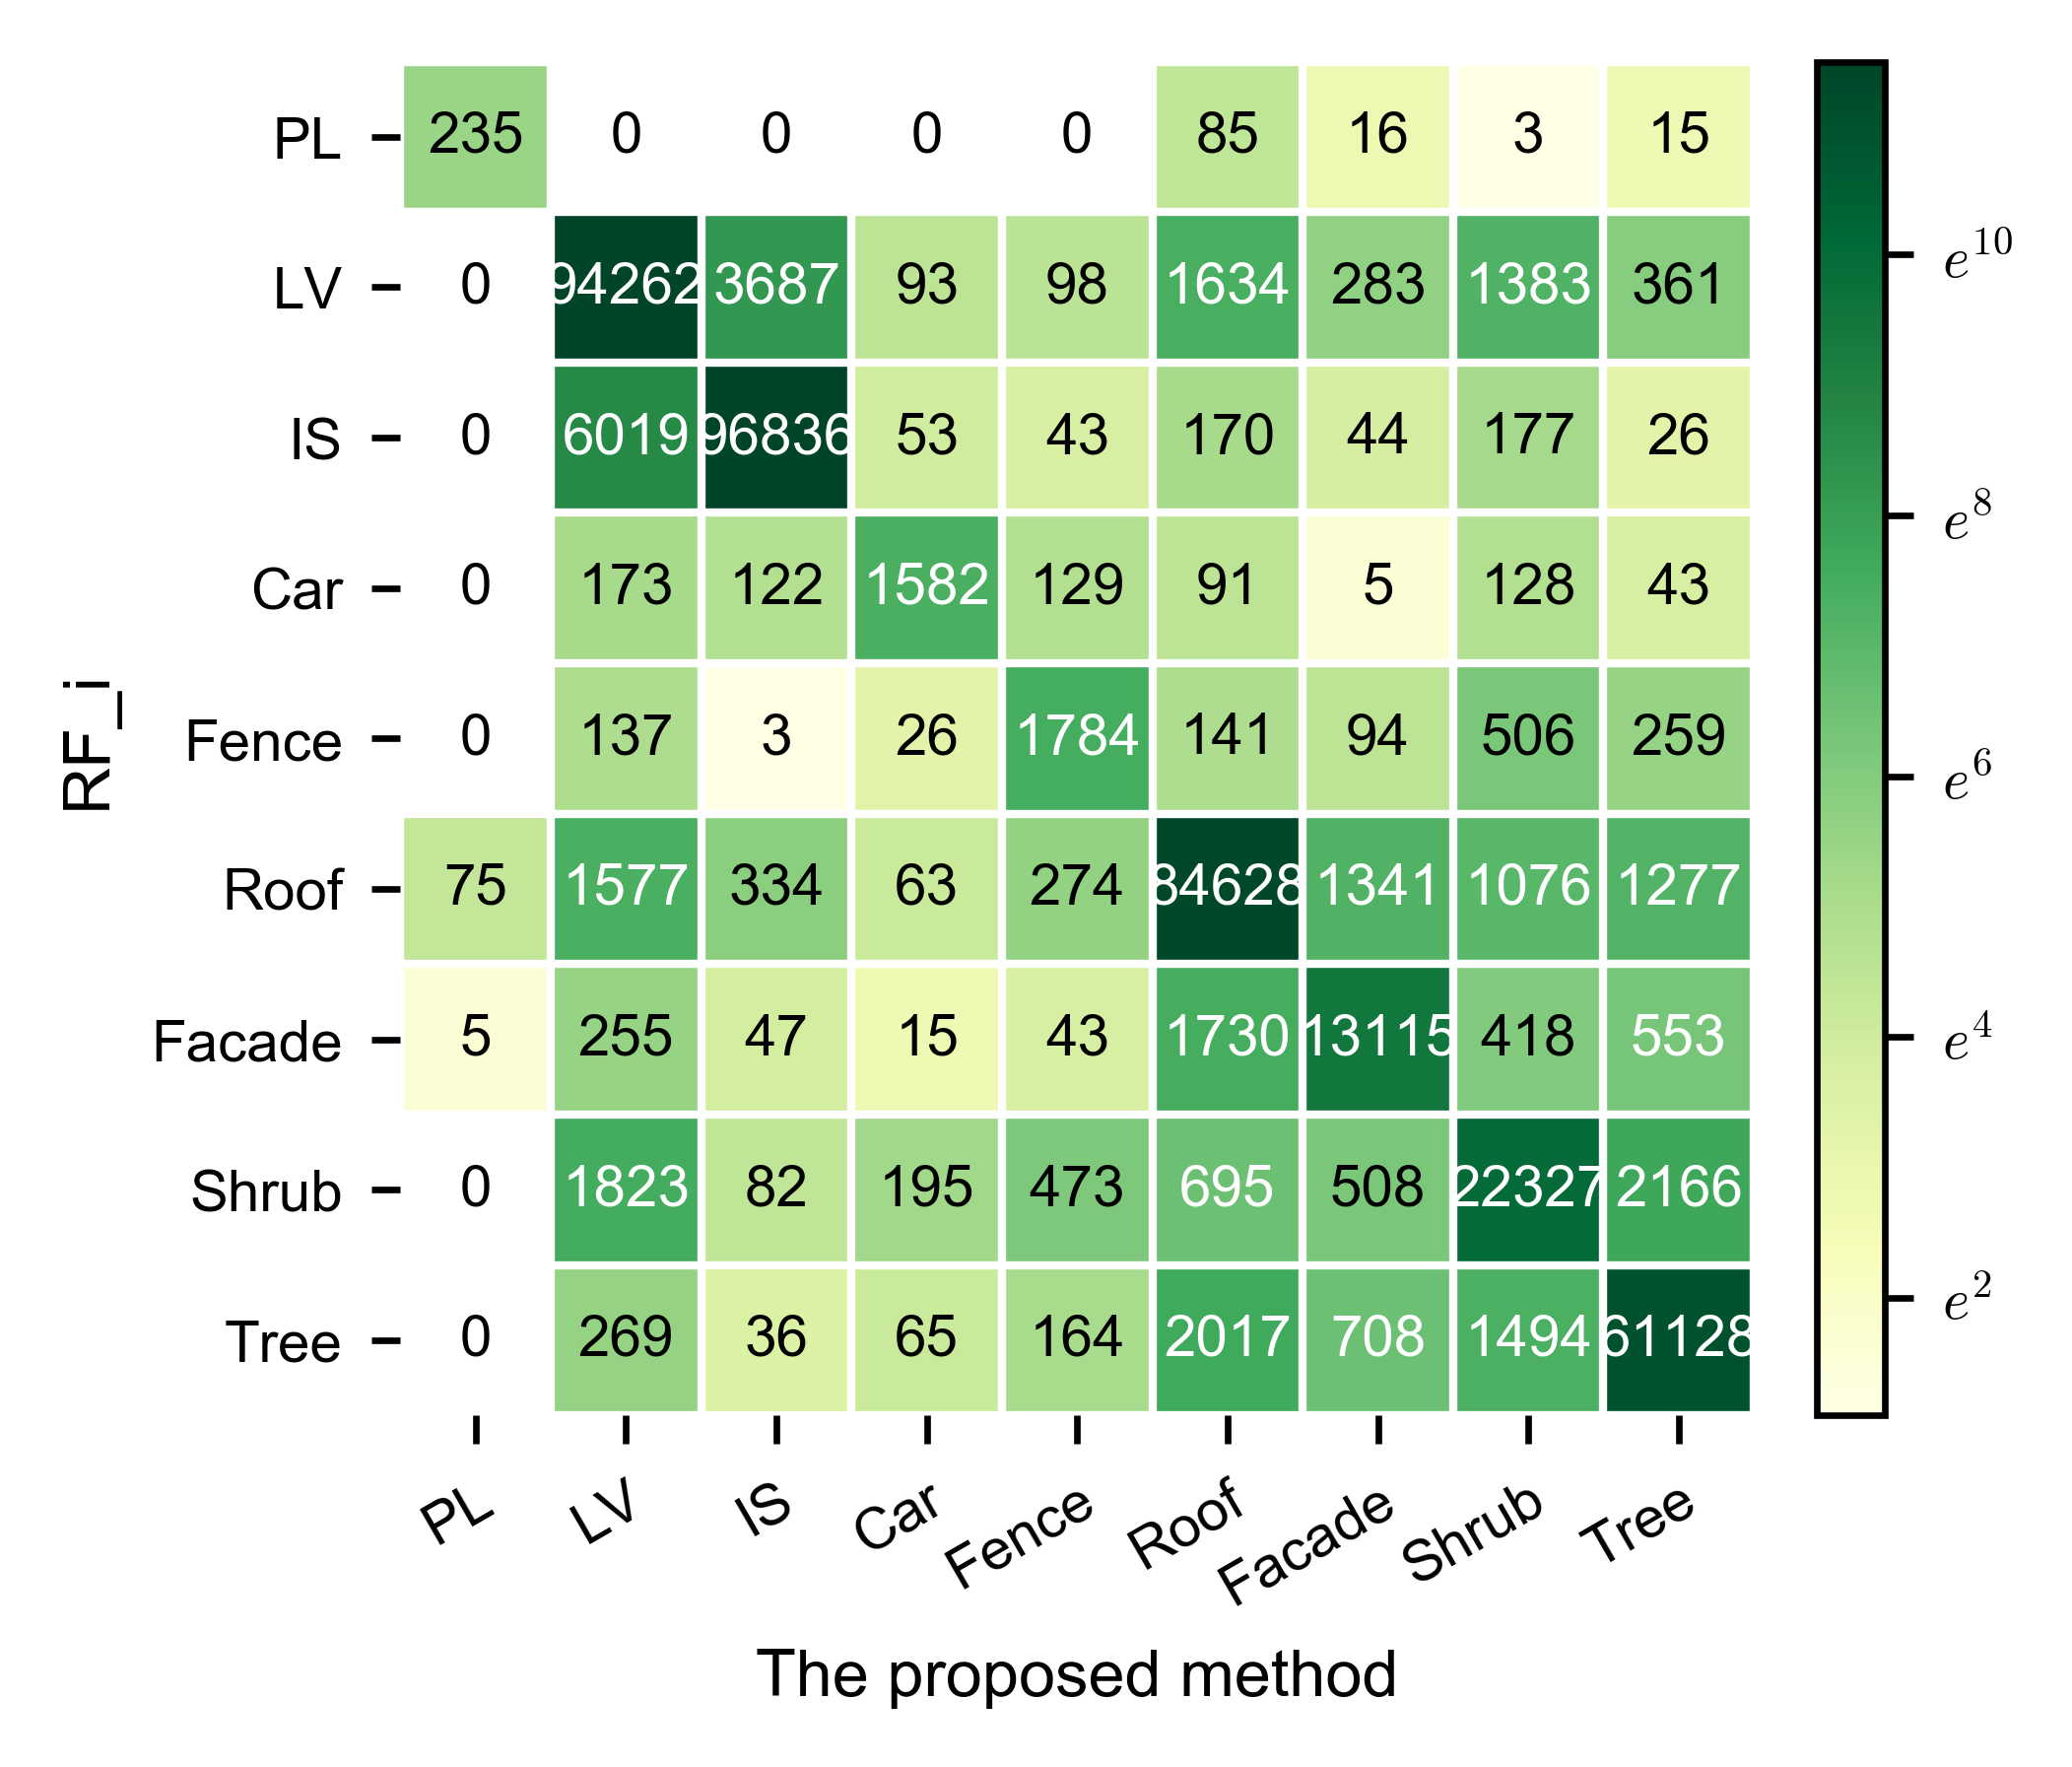

In [41]:
cnf_matrix = confusion_matrix(smooth_SVC_with_i, smooth_joint_result)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(3.5, 3))
im, cbar = plot_confusion_matrix(cnf_matrix, class_name=class_name, ax=ax,
                   cmap="YlGn")
texts = annotate_confusion(im, valfmt="{x:d}", data=cnf_matrix, fontsize=7)
plt.ylabel('RF_i', fontsize=8)
plt.xlabel('The proposed method', fontsize=8)
plt.tight_layout()
plt.savefig("./result/figure/confusion_matrix_RF_i_proposed.png")

#### simulate the intensity using range function

In [42]:
h = test_data[:, -1]
modify = ((500-h) / (700-h))**2
intensity = test_data[:, -7]
modified_intensity = modify * intensity

In [43]:
# smooth modified intensity using mean within k-neighbourhood
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_modified_intensity = modified_intensity[ind]
smooth_modified_intensity = np.average(neigh_modified_intensity, axis=1)
smooth_modified_intensity = smooth_modified_intensity.reshape((-1, 1))

In [44]:
smooth_modified_intensity_scaler = scaler_intensity.transform(smooth_modified_intensity)
test_data_feature_mi = np.hstack((test_data_feature, smooth_modified_intensity_scaler))

In [45]:
SVC_with_mi = clf_SVC_i.predict(test_data_feature_mi)
smooth_SVC_with_mi = smooth_result(SVC_with_mi, ind)

In [46]:
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_SVC_with_mi)

(array([0.0522, 0.7628, 0.6691, 0.4735, 0.5286, 0.8642, 0.3021, 0.3554,
        0.6688]),
 array([0.07  , 0.4227, 0.9637, 0.4426, 0.0486, 0.8088, 0.4086, 0.3225,
        0.8072]),
 array([0.0598, 0.5439, 0.7898, 0.4575, 0.0891, 0.8356, 0.3474, 0.3382,
        0.7315]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [47]:
precision_recall_fscore_support(test_data_class, smooth_SVC_with_mi, average='weighted')

(0.7091003920877479, 0.6960983381990761, 0.679353773334094, None)

#### Joint method for handling intensity after modifying

In [48]:
SVC_lv_im_mi = smooth_modified_intensity[np.logical_or(SVC_without_i == 1, SVC_without_i == 2)]
SVC_lv_im_mi = SVC_lv_im_mi.reshape((-1, 1))
GMM_mi = mixture.GaussianMixture(n_components=2, random_state=0)
GMM_mi.fit(SVC_lv_im_mi)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [49]:
proba_GMM_lv_im_mi = GMM_mi.predict_proba(SVC_lv_im_mi)

# calculate the ratio of larger and smaller
ratio_proba_GMM_lv_im_mi = np.zeros(proba_GMM_lv_im_mi.shape[0])

proba_GMM_lv_larger_im_mi = proba_GMM_lv_im_mi[:, 1] > proba_GMM_lv_im_mi[:, 0]
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 1],
                                                                proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 0])

proba_GMM_lv_smaller_im_mi = np.logical_not(proba_GMM_lv_larger_im_mi)
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 0],
                                                                 proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 1])

In [50]:
SVC_lv_im = SVC_without_i[np.logical_or(SVC_without_i==1, SVC_without_i==2)]

# associate cluster with semantic label using knowledge
GMM_lv_im_mi = GMM_mi.predict(SVC_lv_im_mi)
GMM_lv_im_mi += 1

In [51]:
a = 3                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_SVC_lv_im >= ratio_proba_GMM_lv_im_mi   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im_mi = np.zeros(judge.shape)
refine_lv_im_mi[judge] = SVC_lv_im[judge]
refine_lv_im_mi[np.logical_not(judge)] = GMM_lv_im_mi[np.logical_not(judge)]

joint_result_mi = np.copy(SVC_without_i)
joint_result_mi[np.logical_or(joint_result_mi==1, joint_result_mi==2)] = refine_lv_im_mi
smooth_joint_result_mi = smooth_result(joint_result_mi, ind)

In [52]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi, average='weighted')

(0.7662432993267004, 0.7539431946799053, 0.7558558507117882, None)

In [53]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi)

(array([0.0794, 0.7476, 0.8853, 0.5679, 0.3324, 0.9129, 0.2978, 0.331 ,
        0.658 ]),
 array([0.0417, 0.7886, 0.8815, 0.3204, 0.1349, 0.7634, 0.4276, 0.367 ,
        0.7989]),
 array([0.0546, 0.7675, 0.8834, 0.4097, 0.1919, 0.8315, 0.3511, 0.3481,
        0.7216]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))